In [25]:
import os
import requests
import pandas as pd
import numpy as np
import healpy as hp
import subprocess as sp
import ligo.skymap.plot
import matplotlib.pyplot as plt
from datetime import datetime
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
from tiling import get_time_radius
from ligo.skymap.io import read_sky_map, fits
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [26]:
u_triggers = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/u_triggers.csv"))
u_triggers_with_prob = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/u_triggers_with_probs.csv"))
all_grbs = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/all_grbs.csv"))
all_triggers = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/all_triggers.csv"))
print("Total number of triggers: ", len(u_triggers))
u_triggers_with_link = len(u_triggers[u_triggers['url']!='None'])
print("Total number of triggers with link to some data products: ", u_triggers_with_link)
print("Total number of triggers that have some sort of probability map: ", len(u_triggers_with_prob))
print("Total number of triggers that have healpix map: ", len(u_triggers_with_prob[u_triggers_with_prob['healpix']==0]))
print("Total number of triggers that have locprob (old) map: ", len(u_triggers_with_prob[u_triggers_with_prob['locprob']==0]))
print("Total number of triggers that have both maps: ", len(u_triggers_with_prob[(u_triggers_with_prob['healpix']==0) & (u_triggers_with_prob['locprob']==0)]))
print("Total number of GRBs confirmed by Fermi: ", len(all_grbs))
real_grbs = all_grbs['trigger_name'].values
triggers_with_prob = u_triggers_with_prob['GRBName'].values
grb_with_prob = np.intersect1d(real_grbs, triggers_with_prob)
real_grb_triggers = []
for real_grb in real_grbs:
    real_grb_triggers.append(np.unique(u_triggers[u_triggers['url'].str.contains(real_grb)]['trigger_no'].values))
real_grb_triggers = np.concatenate(real_grb_triggers)
real_grb_triggers_with_prob = np.intersect1d(real_grb_triggers, u_triggers_with_prob['Trig_no'].values)
grb_with_link = np.intersect1d(real_grb_triggers, u_triggers['trigger_no'].values)
print("Total number of real GRBs with link to some data products: ", len(grb_with_link))
print("Total number of real GRBs that have corresponding probability maps: ", len(grb_with_prob))
print(np.setdiff1d(real_grbs, triggers_with_prob),"\nThe above GRBs do not have probability maps")
long_grbs = np.unique(all_triggers[all_triggers['Comments'].str.contains("Long GRB")]['TrigNum'].values)
actual_long_grb = np.intersect1d(long_grbs, real_grb_triggers)
actual_long_grb_with_prob = np.intersect1d(long_grbs, real_grb_triggers_with_prob)
short_grbs = np.unique(all_triggers[all_triggers['Comments'].str.contains("Short GRB")]['TrigNum'].values)
actual_short_grb = np.intersect1d(short_grbs, real_grb_triggers)
actual_short_grb_with_prob = np.intersect1d(short_grbs, real_grb_triggers_with_prob)
print("Total number of triggers reported as likely Long GRBs: ", len(long_grbs))
print("Out of the these, the number of real GRBs: ", len(actual_long_grb))
print("Out of the these, the number of real GRBs that have probability maps: ", len(actual_long_grb_with_prob))
print("Total number of triggers reported as likely Short GRBs: ", len(short_grbs))
print("Out of the these, the number of real GRBs: ", len(actual_short_grb))
print("Out of the these, the number of real GRBs that have probability maps: ", len(actual_short_grb_with_prob))

Total number of triggers:  3766
Total number of triggers with link to some data products:  3760
Total number of triggers that have some sort of probability map:  1761
Total number of triggers that have healpix map:  1409
Total number of triggers that have locprob (old) map:  1652
Total number of triggers that have both maps:  1301
Total number of GRBs confirmed by Fermi:  1603
Total number of real GRBs with link to some data products:  1546
Total number of real GRBs that have corresponding probability maps:  1499
['bn170307851' 'bn170430204' 'bn170614505' 'bn170626401' 'bn170726794'
 'bn170926782' 'bn171010875' 'bn171120556' 'bn171212948' 'bn171222684'
 'bn180204109' 'bn180205184' 'bn180618030' 'bn180620660' 'bn180706351'
 'bn180917477' 'bn181016718' 'bn181125371' 'bn181126413' 'bn181225489'
 'bn190109497' 'bn190123513' 'bn190311600' 'bn190323548' 'bn190427190'
 'bn190531568' 'bn190716019' 'bn190821716' 'bn191119261' 'bn191130507'
 'bn200224416' 'bn200416295' 'bn200630076' 'bn200829582

In [27]:
coverage = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/coverage.csv"))
total_maps_tiled = len(coverage['coverage'].values[np.where(np.logical_and(coverage['coverage'].values!='None', coverage['coverage'].values!='DID NOT RISE'))])
print("Total number of probability maps tiled: ", total_maps_tiled)
print(f"Total time taken:  25000 seconds ~ {np.round(25000/total_maps_tiled, 2)} seconds per map")

Total number of probability maps tiled:  996
Total time taken:  25000 seconds ~ 25.1 seconds per map


In [28]:
PIX_AREA = hp.nside2pixarea(128, degrees=True)
def get_loc_size(healpix, frac=0.9):
    hpmap = read_sky_map(healpix)[0]
    sortorder = np.argsort(hpmap)[::-1]
    n_pix = len(sortorder[:np.where(np.cumsum(hpmap[sortorder])/np.sum(hpmap)>frac)[0][0]])
    return n_pix*PIX_AREA

In [29]:
radius = coverage['radius'].values
probs = coverage['coverage'].values
healpix = coverage['healpix'].values
radius = radius[np.where(np.logical_and(np.logical_and(probs!='NOT VISIBLE',probs!='None'), probs!="DID NOT RISE"))].astype(float)
healpix = healpix[np.where(np.logical_and(np.logical_and(probs!='NOT VISIBLE',probs!='None'), probs!="DID NOT RISE"))]
probs = probs[np.where(np.logical_and(np.logical_and(probs!='NOT VISIBLE',probs!='None'), probs!="DID NOT RISE"))].astype(float)
probs = probs[radius<30]
healpix = healpix[radius<30]
radius = radius[radius<30]
probs = probs[np.argsort(radius)]
healpix = healpix[np.argsort(radius)]
radius = radius[np.argsort(radius)]
area, times, dates = [], [], []
for heal in healpix:
    date = datetime.strptime(heal.split("_")[3][2:8], "%y%m%d")
    file = "/home/ravioli/astro/git/fermi_grbs/data/"+heal
    covragefile = "/home/ravioli/astro/git/fermi_grbs/data/"+heal+"_scheduled.csv"
    times.append(len(pd.DataFrame(pd.read_csv(covragefile)))*5)
    area.append(get_loc_size(file, frac=0.5))
    dates.append(date)
dates = np.array(dates)
area = np.array(area)
times = np.array(times)

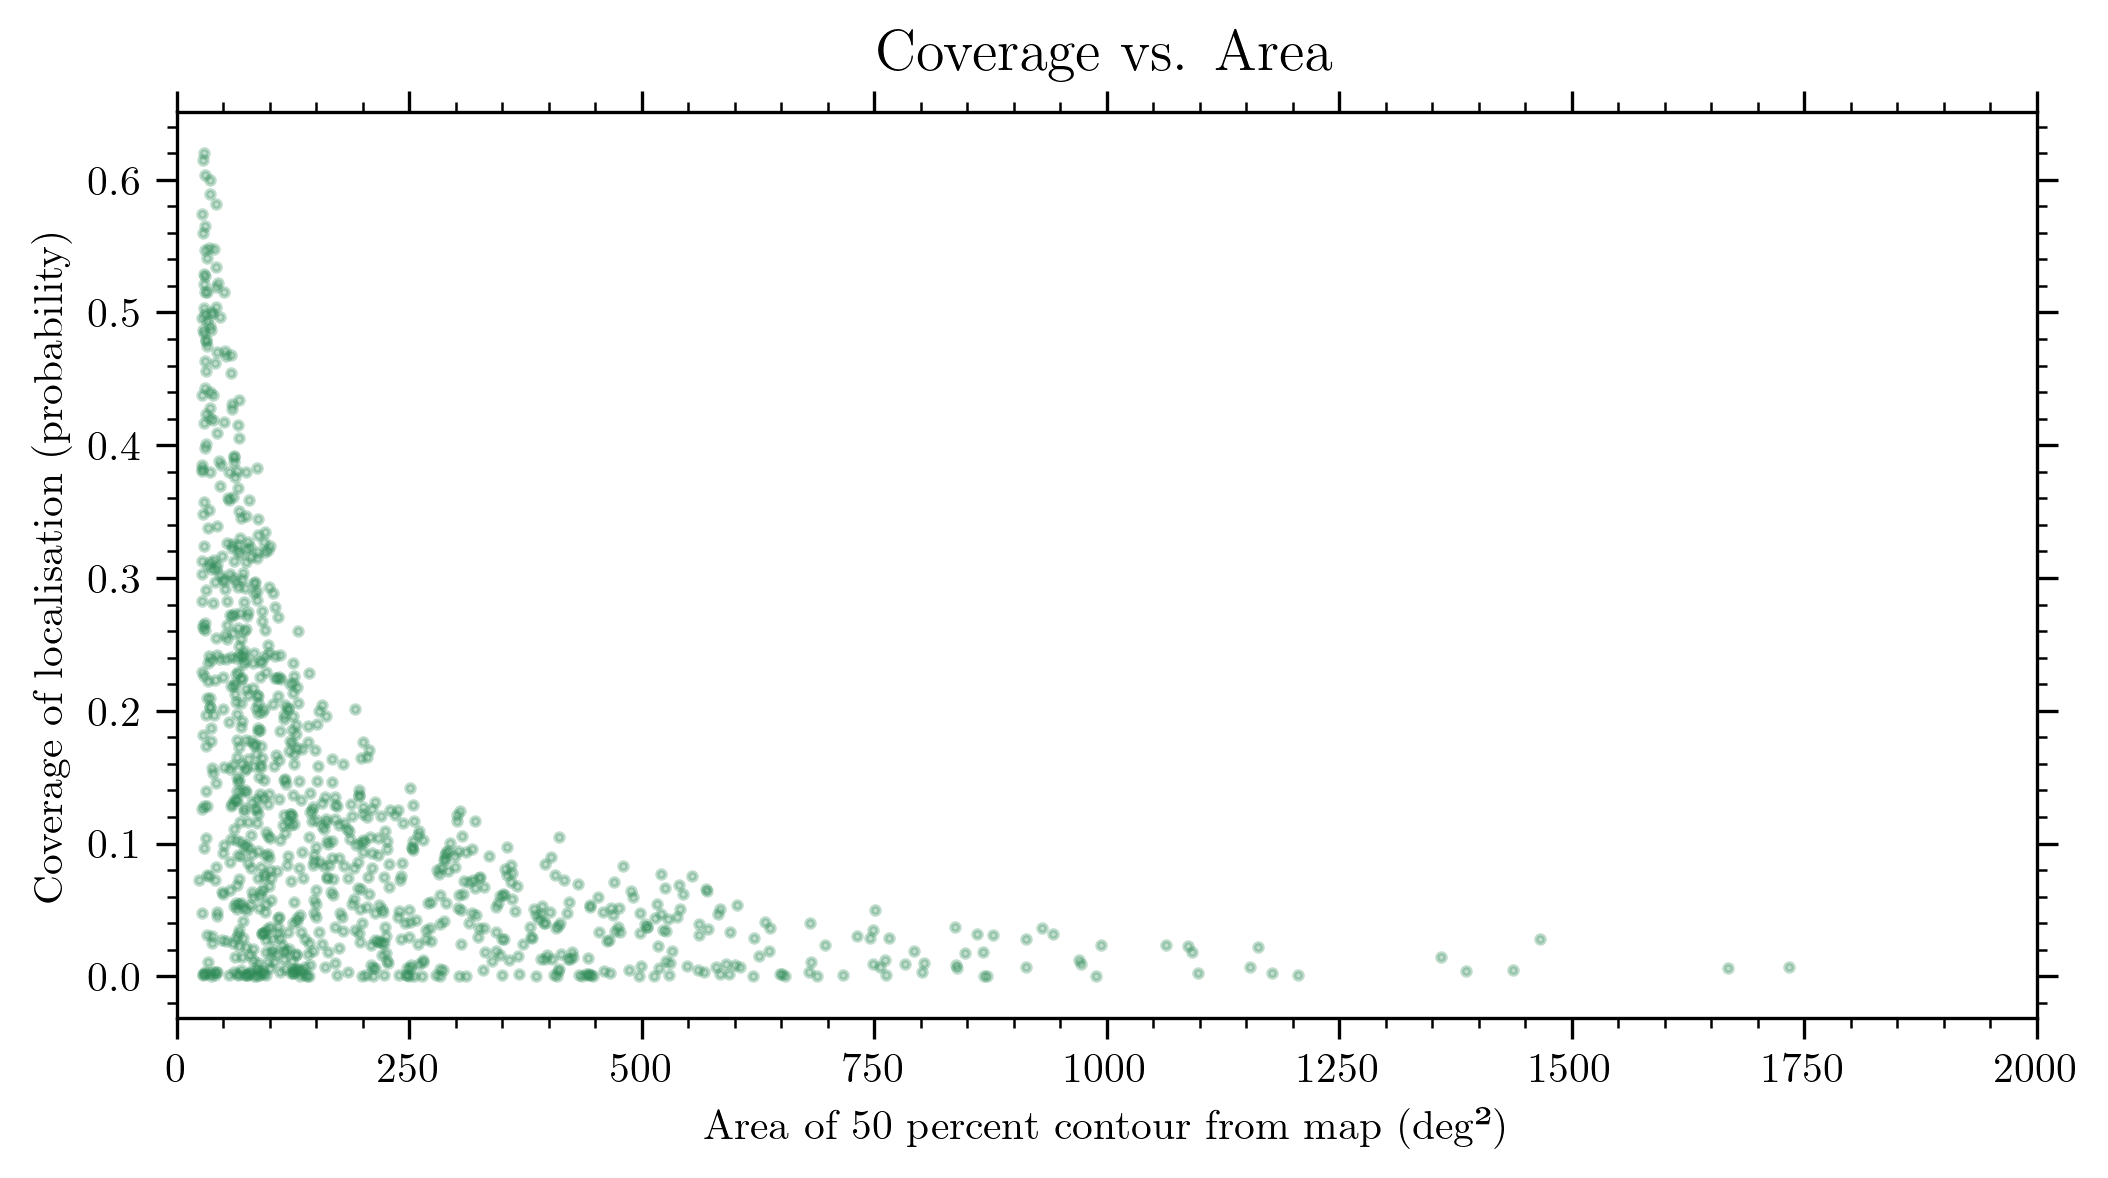

In [30]:
plt.figure(figsize=(8,4), dpi=300)
plt.scatter(area, probs, s=4, color='seagreen', alpha=0.3)
plt.xlabel("Area of 50 percent contour from map (deg²)")
plt.ylabel("Coverage of localisation (probability)")
plt.title("Coverage vs. Area", fontsize=14, pad=10)
plt.xlim(0,2000)
plt.show()

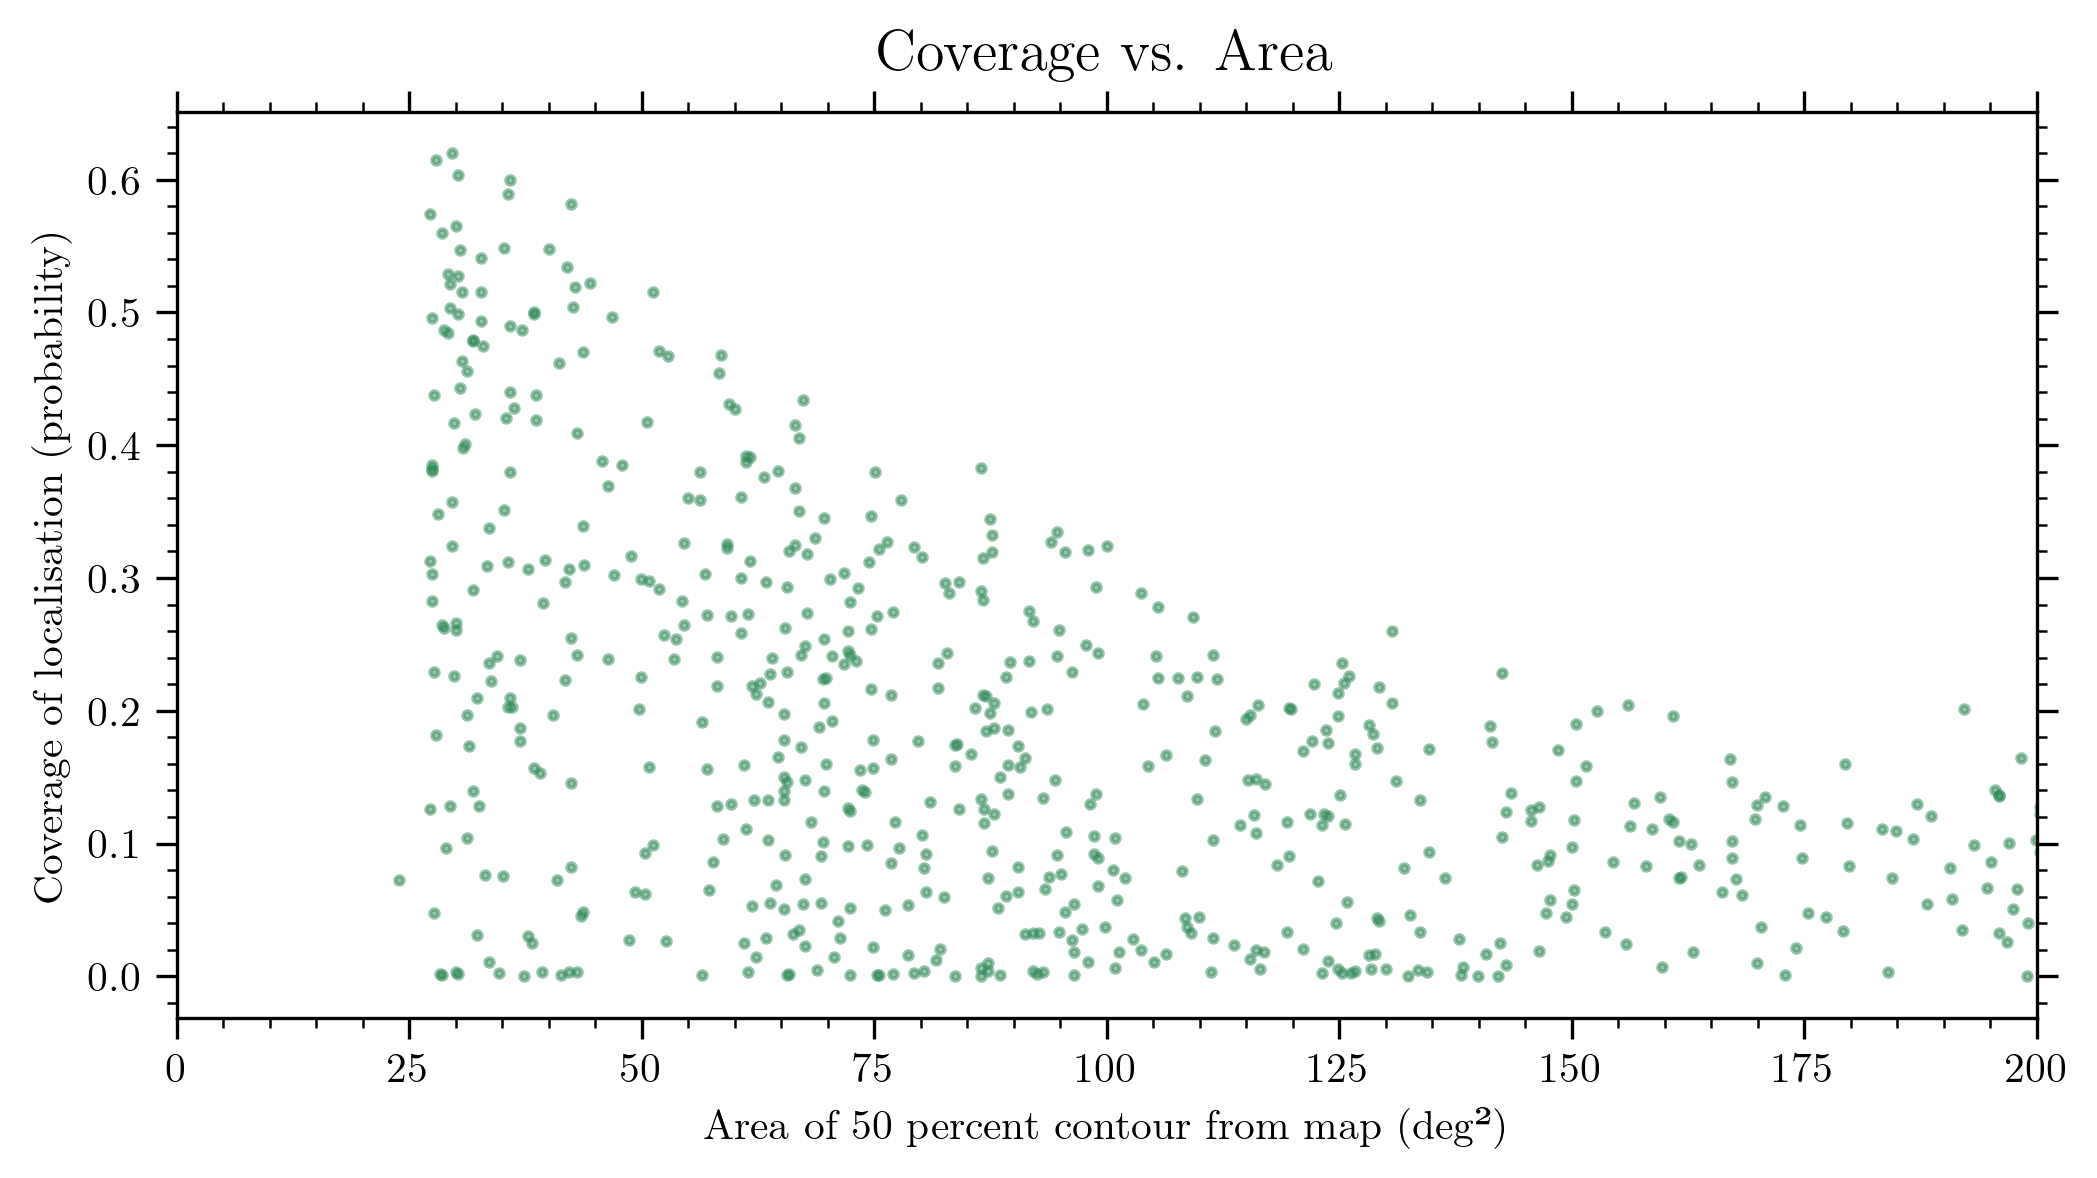

In [31]:
plt.figure(figsize=(8,4), dpi=300)
plt.scatter(area, probs, s=4, color='seagreen', alpha=0.5)
plt.xlabel("Area of 50 percent contour from map (deg²)")
plt.ylabel("Coverage of localisation (probability)")
plt.title("Coverage vs. Area", fontsize=14, pad=10)
plt.xlim(0,200)
plt.show()

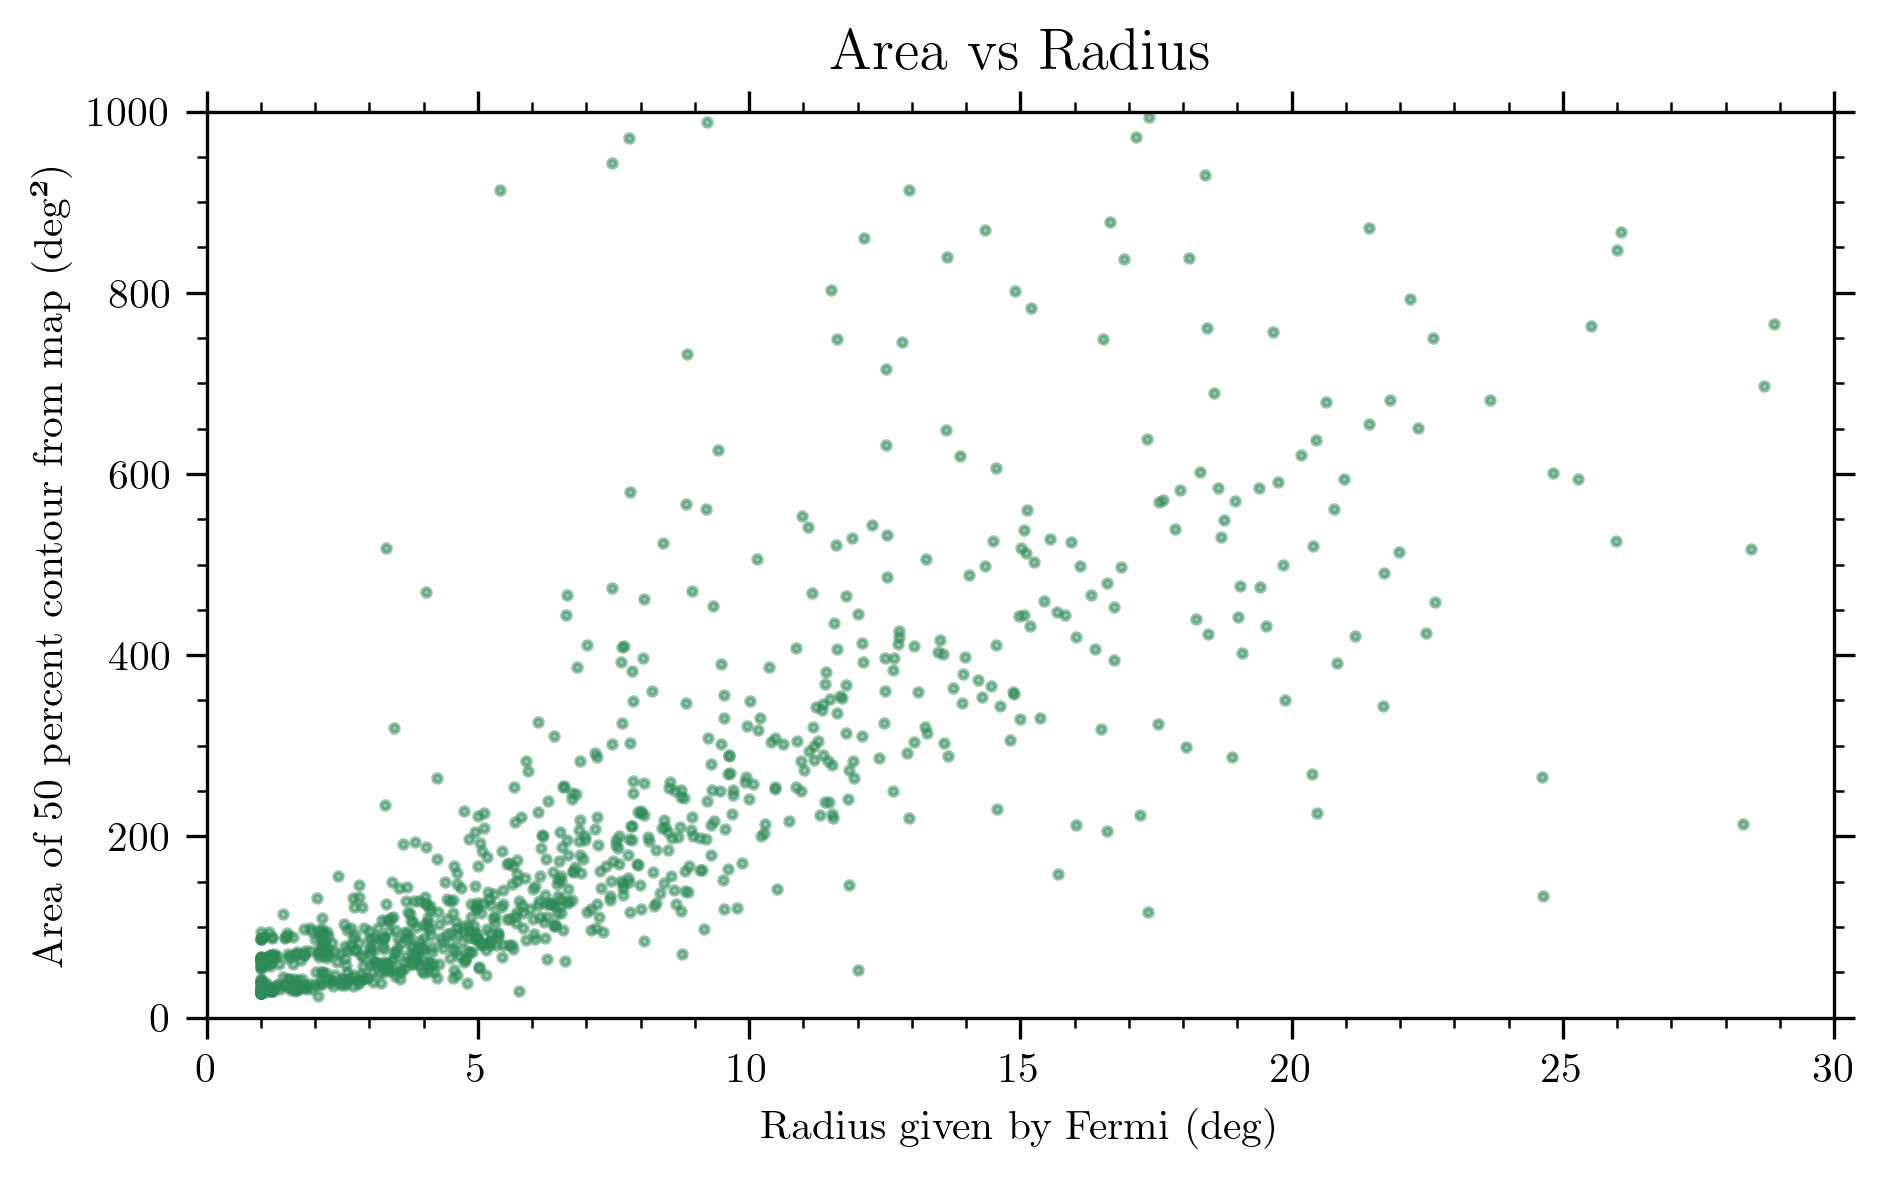

In [32]:
plt.figure(figsize=(7,4), dpi=300)
plt.scatter(radius, area, s=4, color='seagreen', alpha=0.5)
plt.xlabel("Radius given by Fermi (deg)")
plt.ylabel("Area of 50 percent contour from map (deg²)")
plt.title("Area vs Radius", fontsize=14, pad=10)
plt.ylim(0,1000)
plt.xlim(0,30)
plt.show()

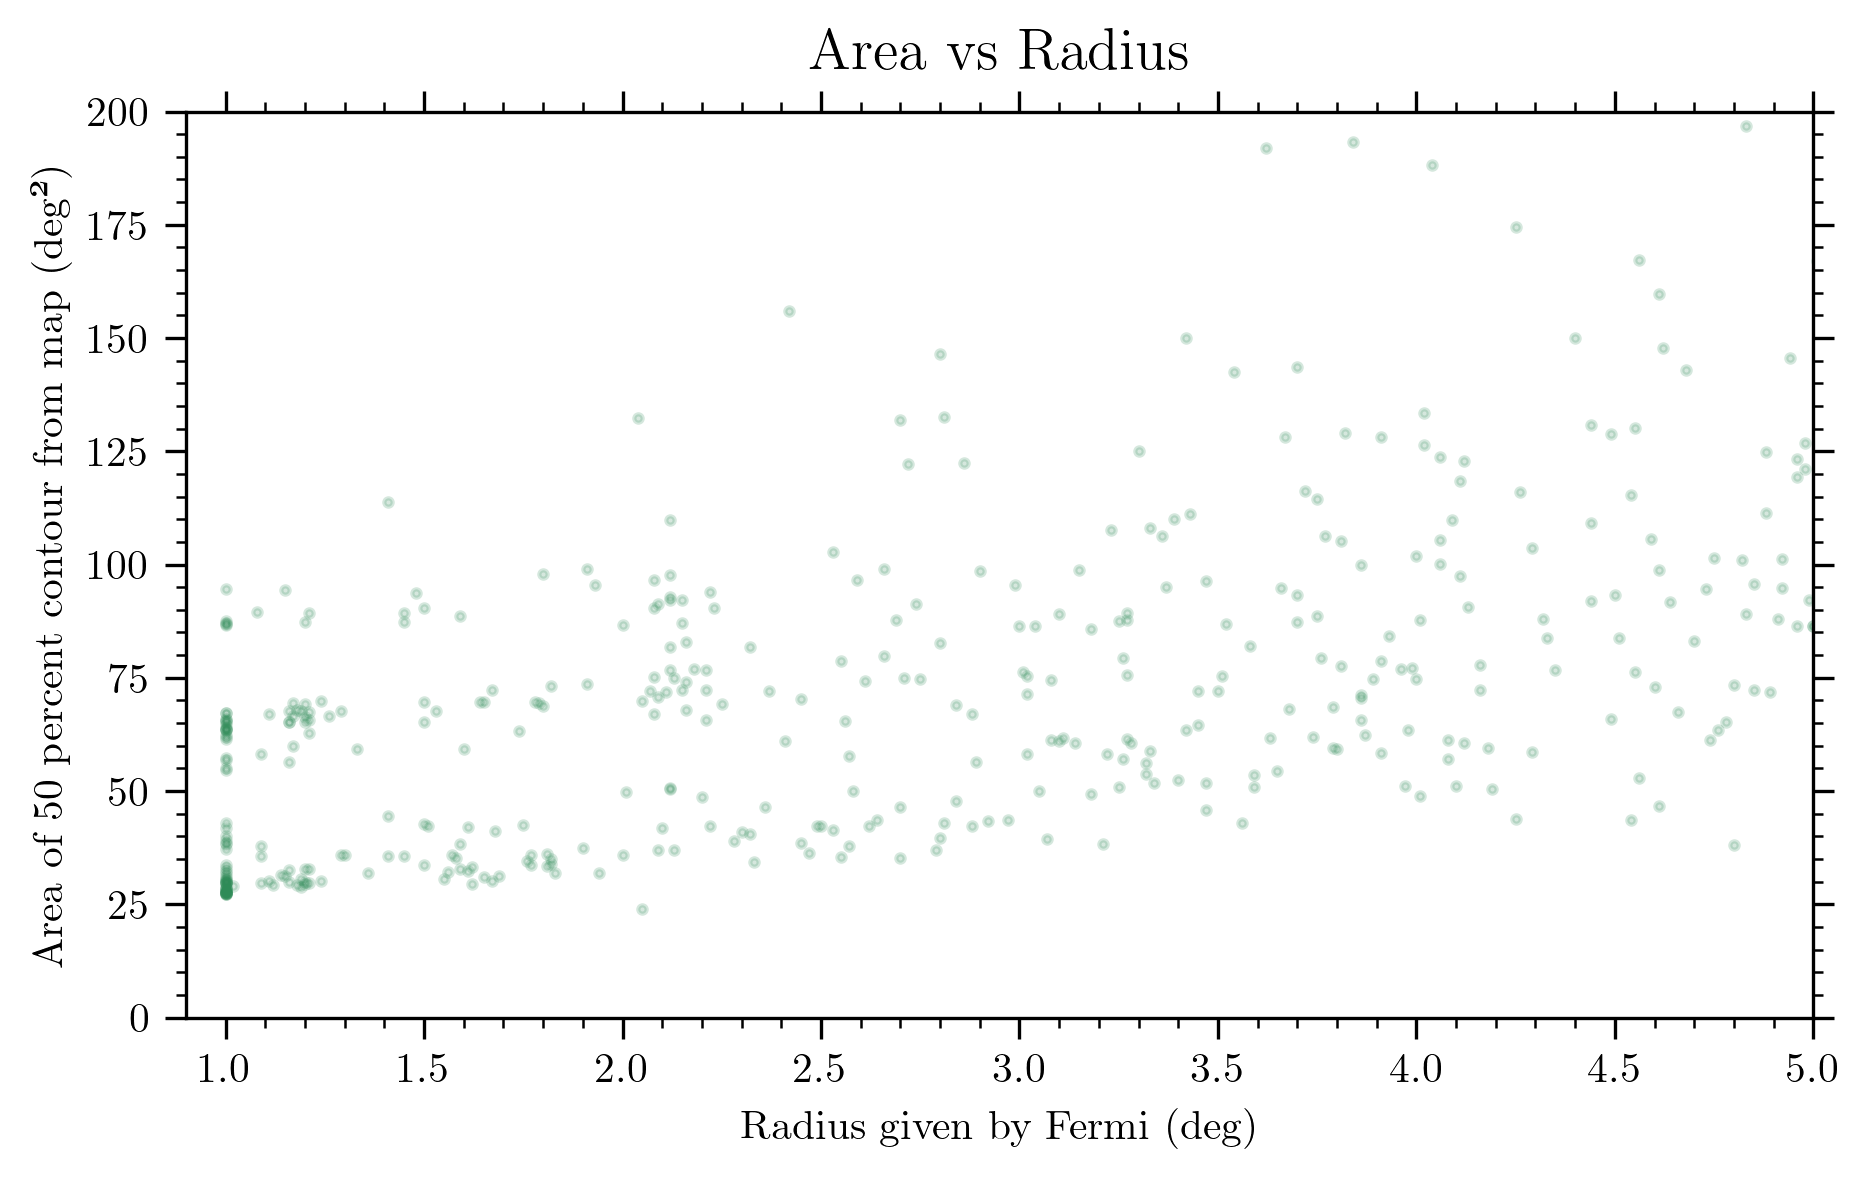

In [33]:
plt.figure(figsize=(7,4), dpi=300)
plt.scatter(radius, area, s=4, color='seagreen', alpha=0.2)
plt.xlabel("Radius given by Fermi (deg)")
plt.ylabel("Area of 50 percent contour from map (deg²)")
plt.title("Area vs Radius", fontsize=14, pad=10)
plt.ylim(0,200)
plt.xlim(0.9,5)
plt.show()

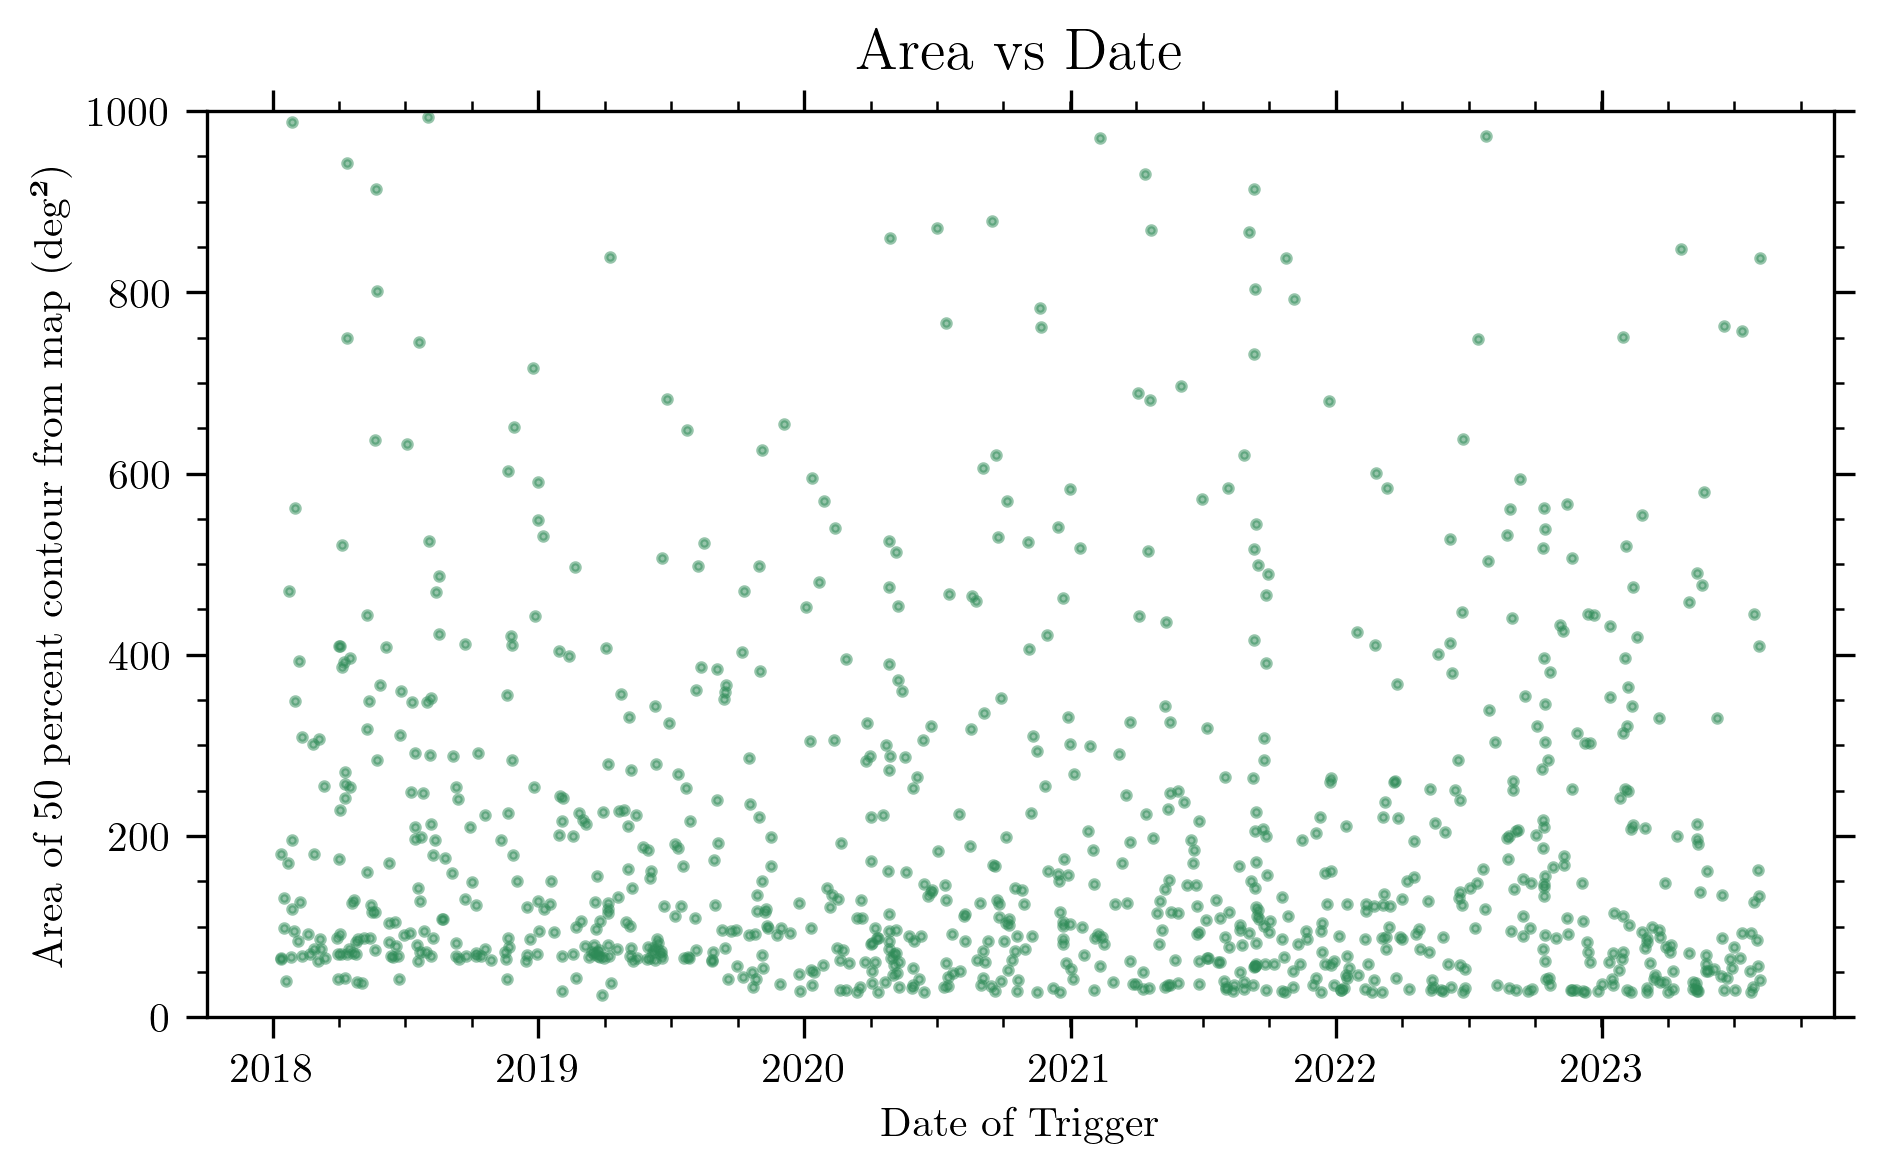

In [34]:
plt.figure(figsize=(7,4), dpi=300)
plt.scatter(dates, area, s=4, color='seagreen', alpha=0.5)
plt.xlabel("Date of Trigger")
plt.ylabel("Area of 50 percent contour from map (deg²)")
plt.title("Area vs Date", fontsize=14, pad=10)
plt.ylim(0,1000)
# plt.xlim(0.9,5)
plt.show()

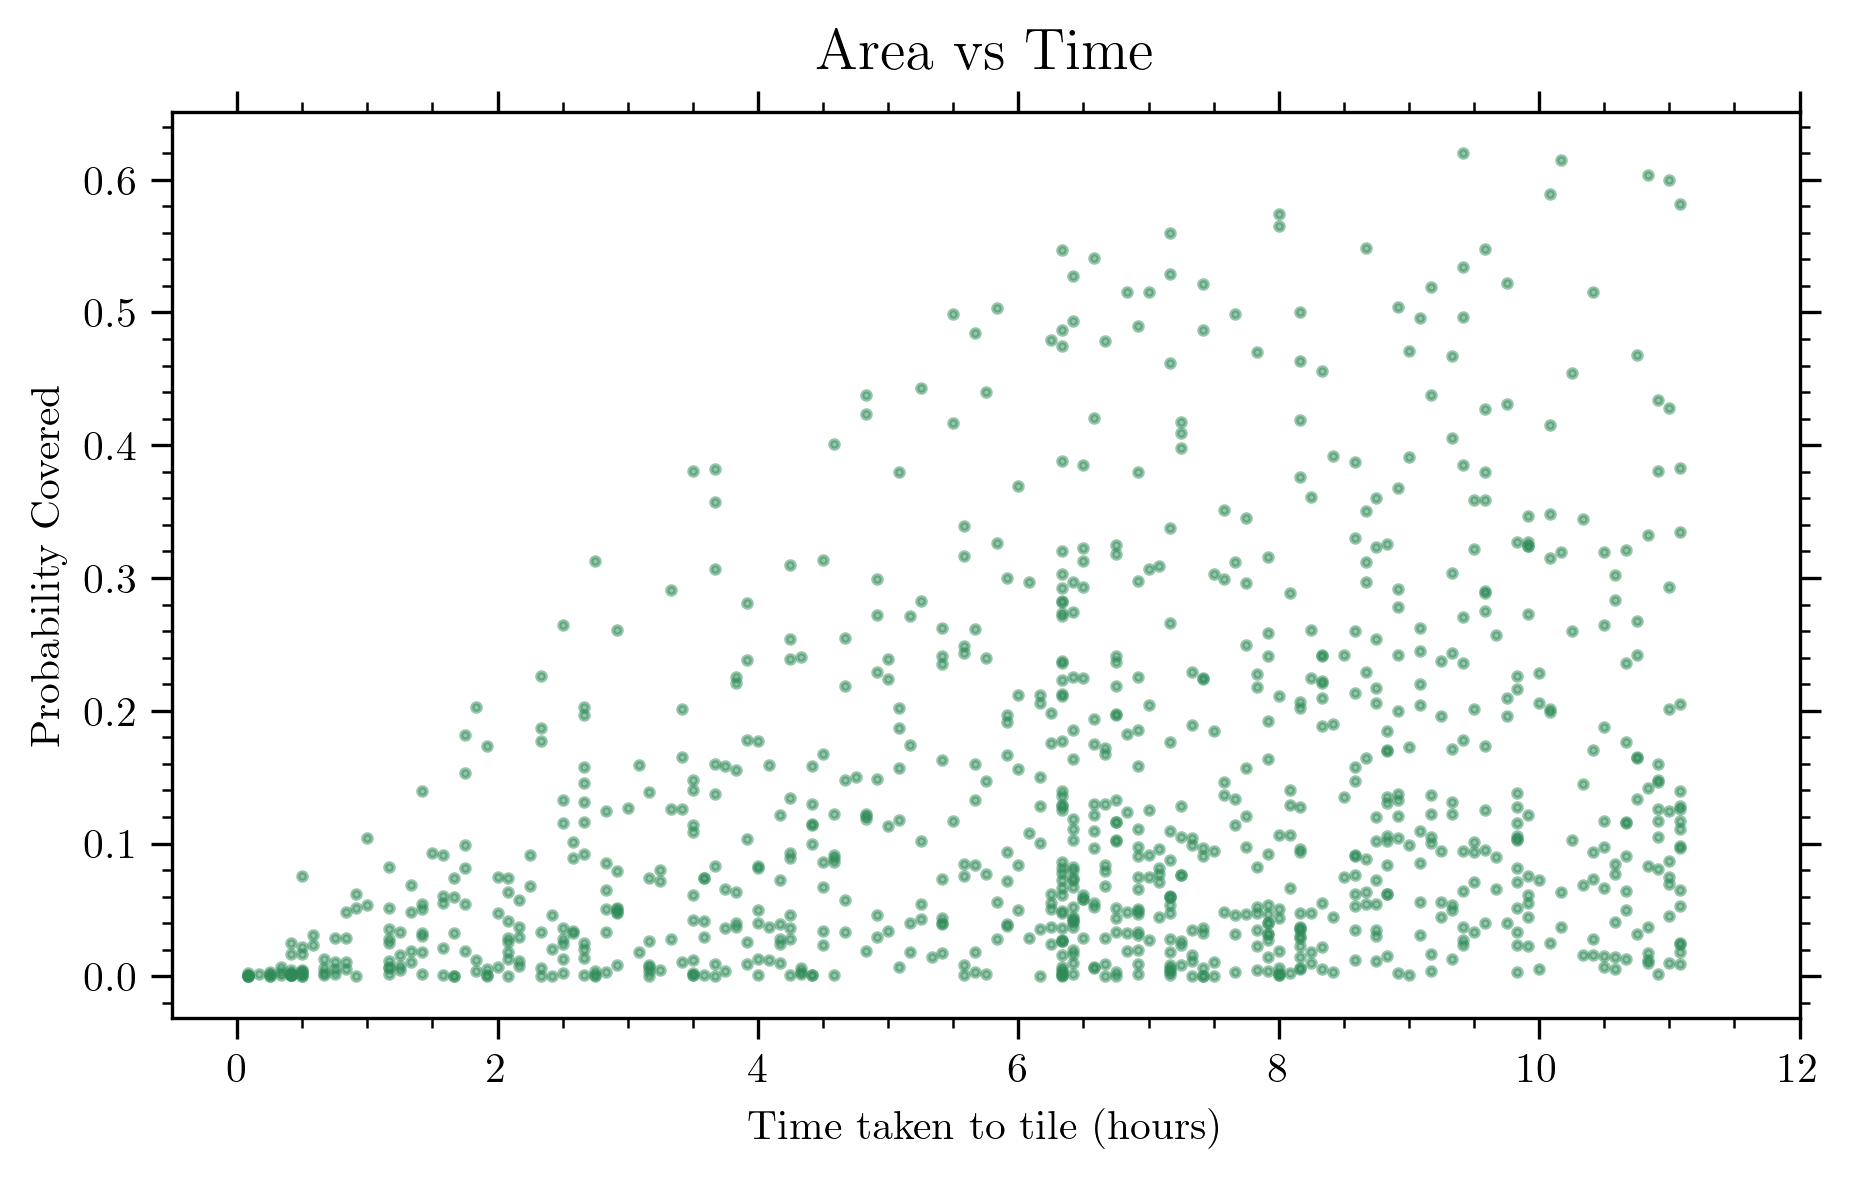

In [35]:
plt.figure(figsize=(7,4), dpi=300)
plt.scatter(times/60, probs, s=4, color='seagreen', alpha=0.5)
plt.xlabel("Time taken to tile (hours)")
plt.ylabel("Probability Covered")
plt.title("Area vs Time", fontsize=14, pad=10)
# plt.ylim(0,200)
plt.xlim(-0.5,12)
plt.show()

In [36]:
print("High probab:", np.sum(probs > 0.3))
print("Small radius: ", np.sum(radius < 6))

High probab: 126
Small radius:  506


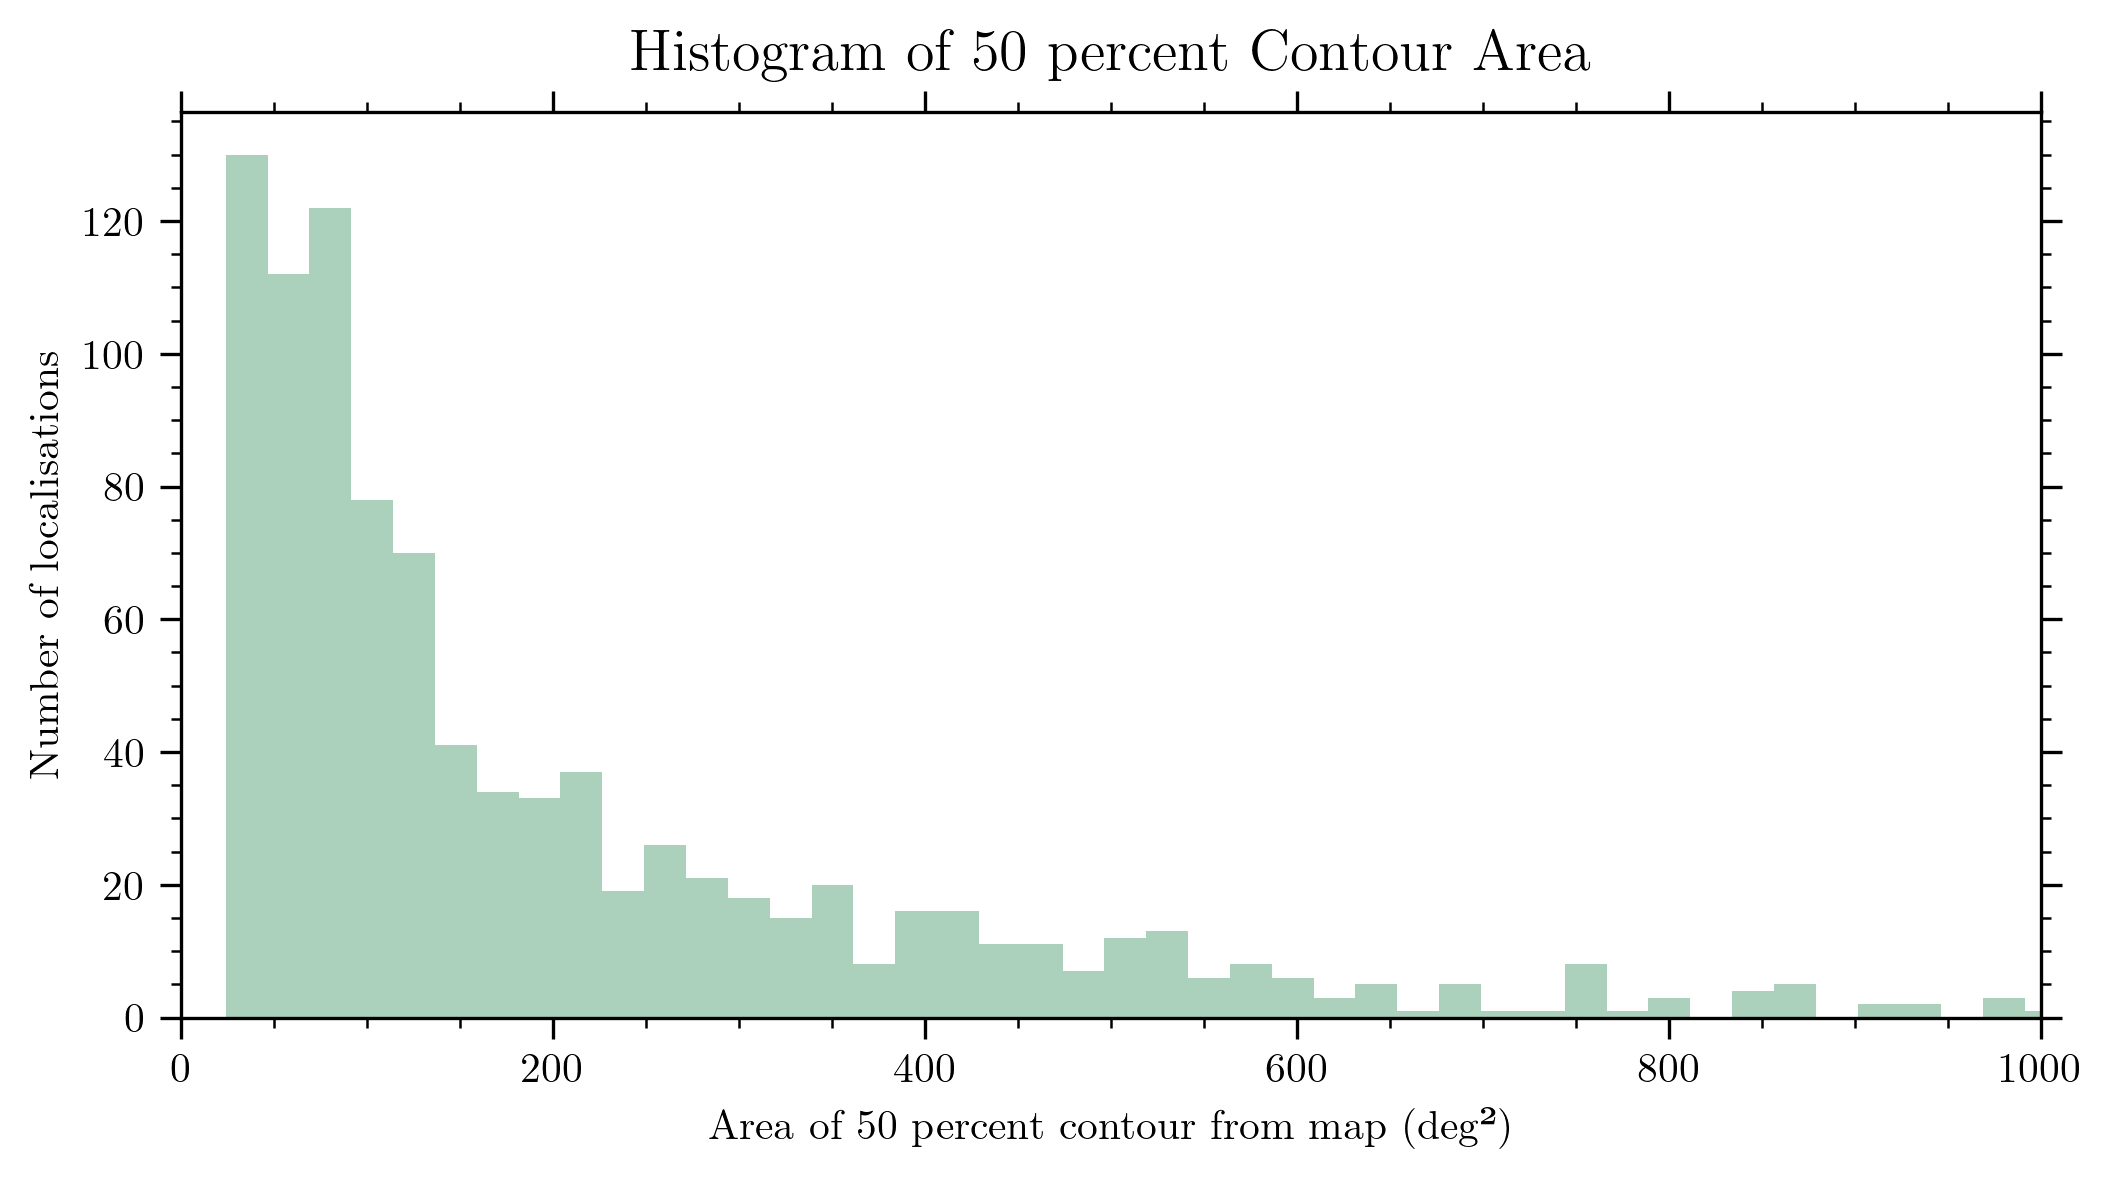

In [37]:
plt.figure(figsize=(8,4), dpi=300)
plt.hist(area, bins=250, color='seagreen', alpha=0.4)
plt.xlabel("Area of 50 percent contour from map (deg²)")
plt.ylabel("Number of localisations")
plt.title("Histogram of 50 percent Contour Area", fontsize=14, pad=10)
plt.xlim(0,1000)
plt.show()

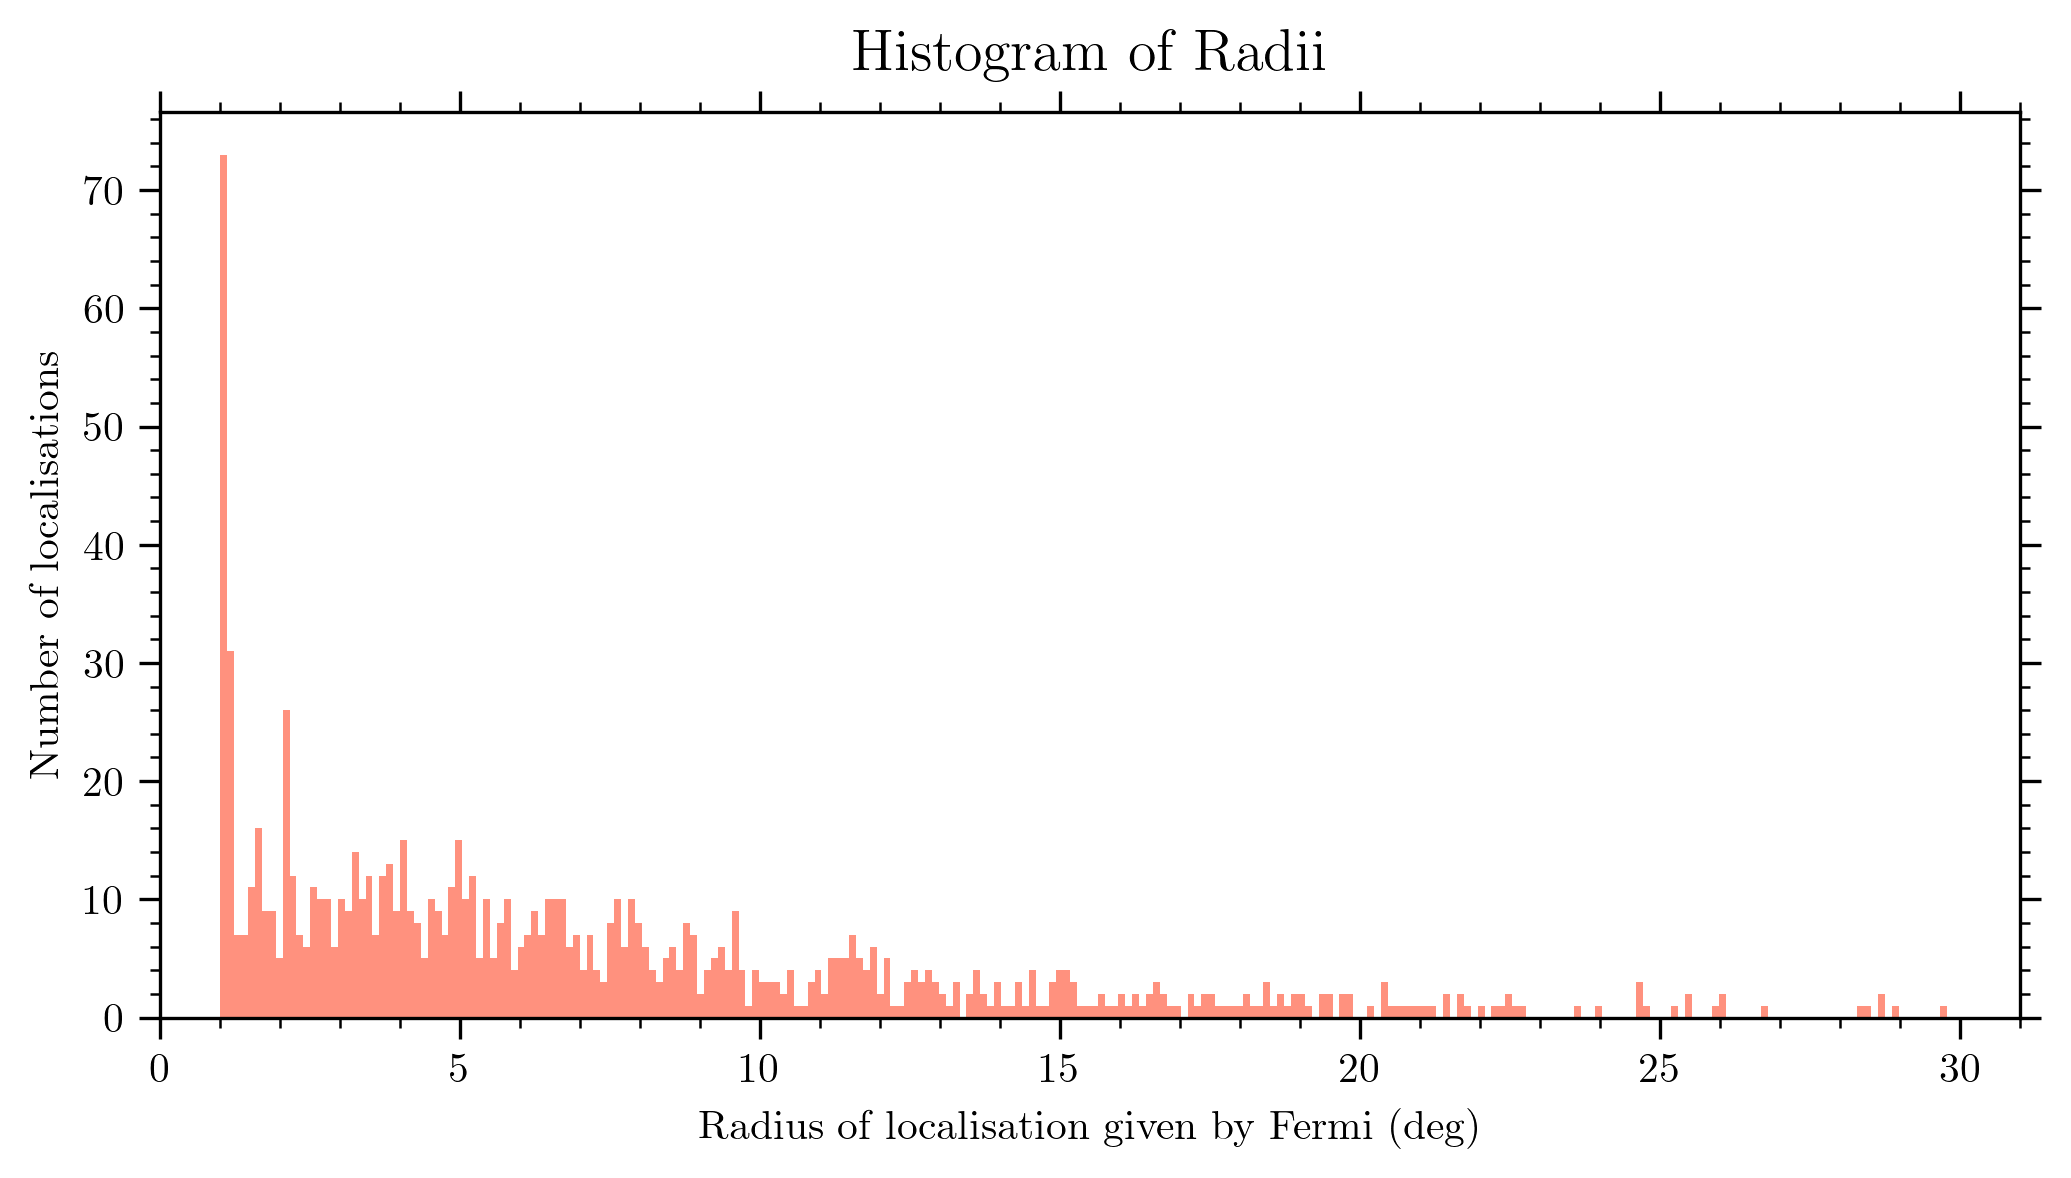

In [38]:
plt.figure(figsize=(8,4), dpi=300)
plt.hist(radius, bins=250, color='tomato', alpha=0.7)
plt.xlabel("Radius of localisation given by Fermi (deg)")
plt.ylabel("Number of localisations")
plt.title("Histogram of Radii", fontsize=14, pad=10)
plt.xlim(0,31)
plt.show()

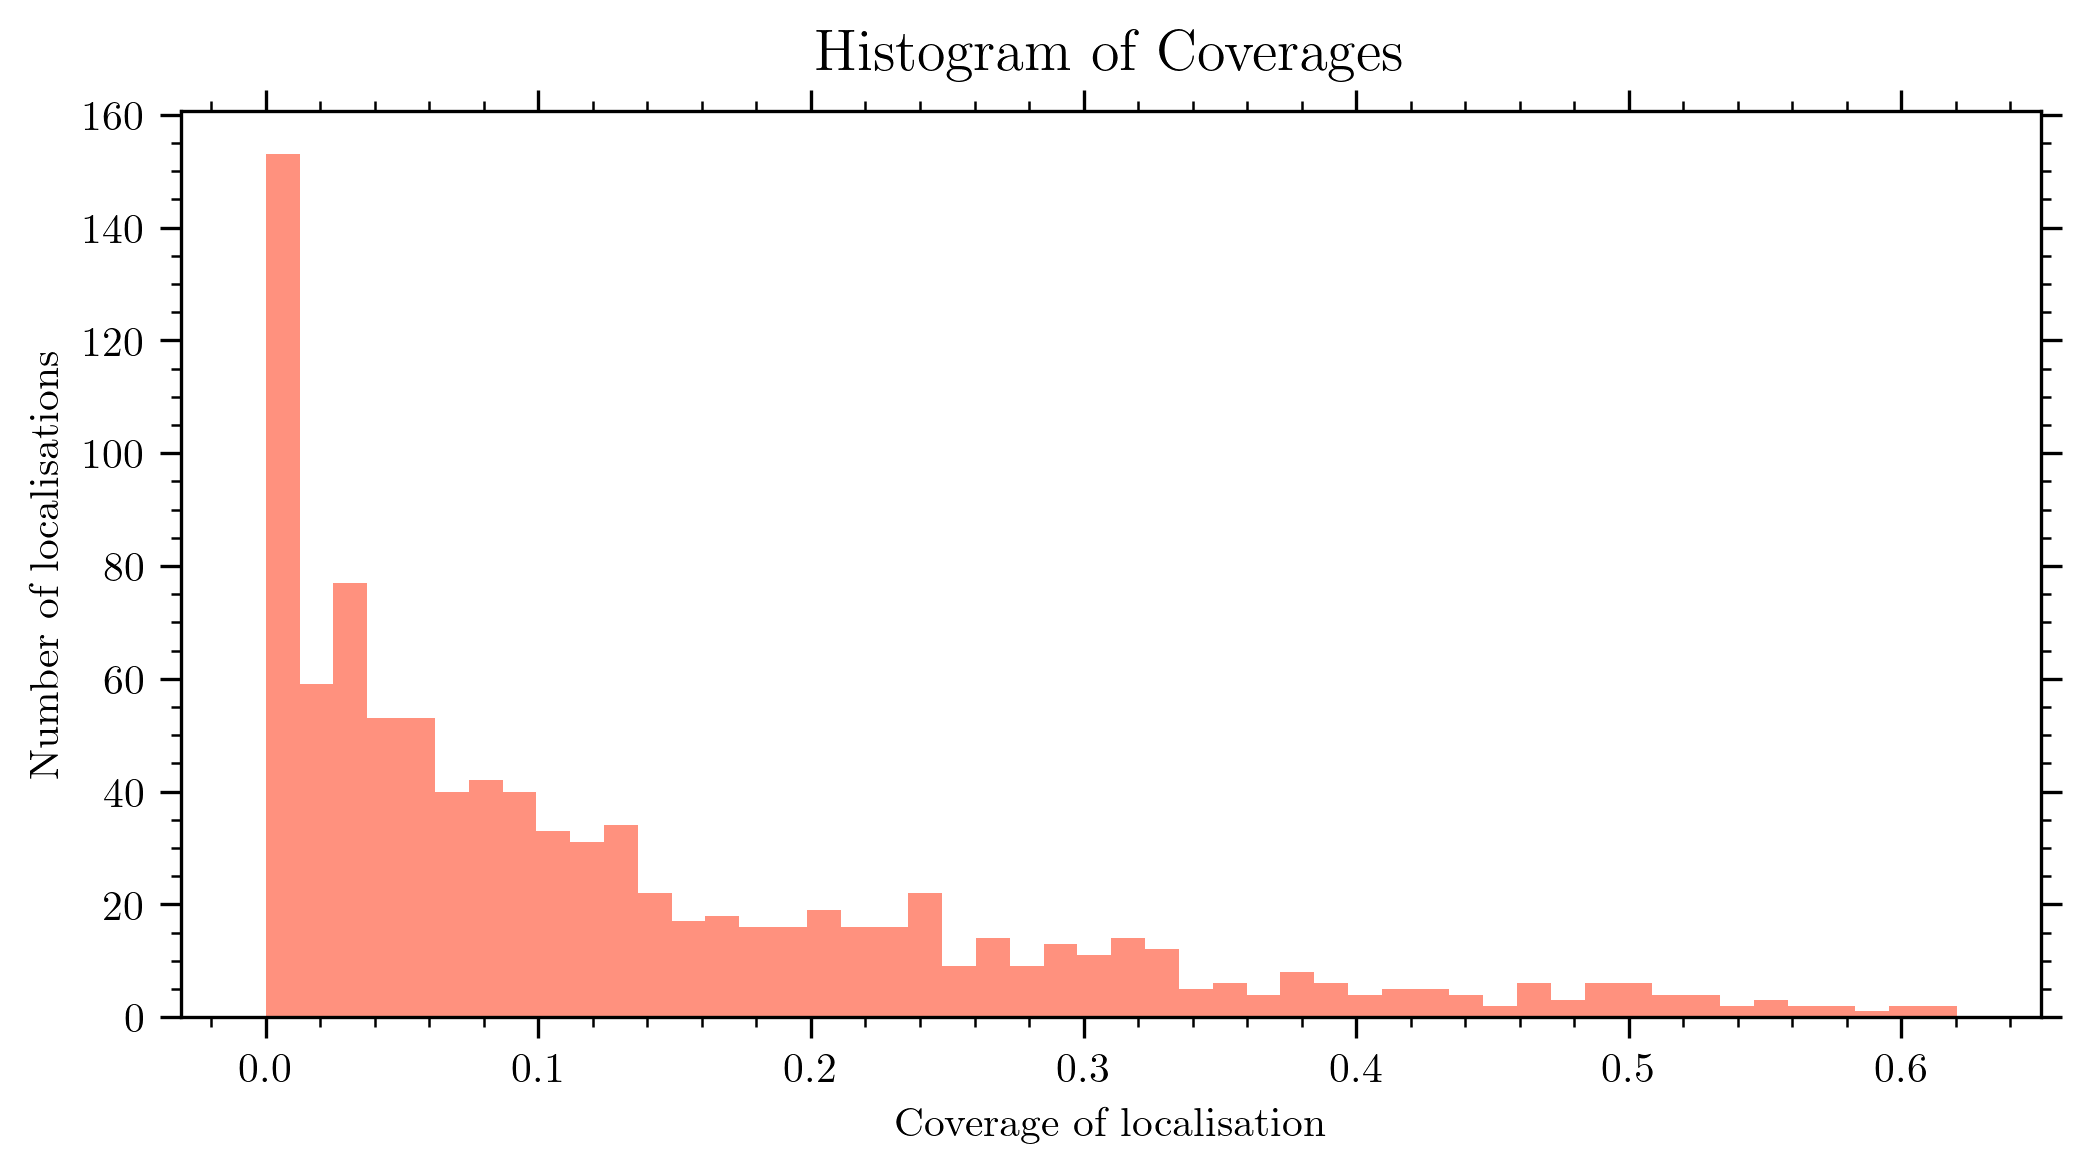

In [39]:
plt.figure(figsize=(8,4), dpi=300)
plt.hist(probs, bins=50, color='tomato', alpha=0.7)
plt.xlabel("Coverage of localisation")
plt.ylabel("Number of localisations")
plt.title("Histogram of Coverages", fontsize=14, pad=10)
plt.show()

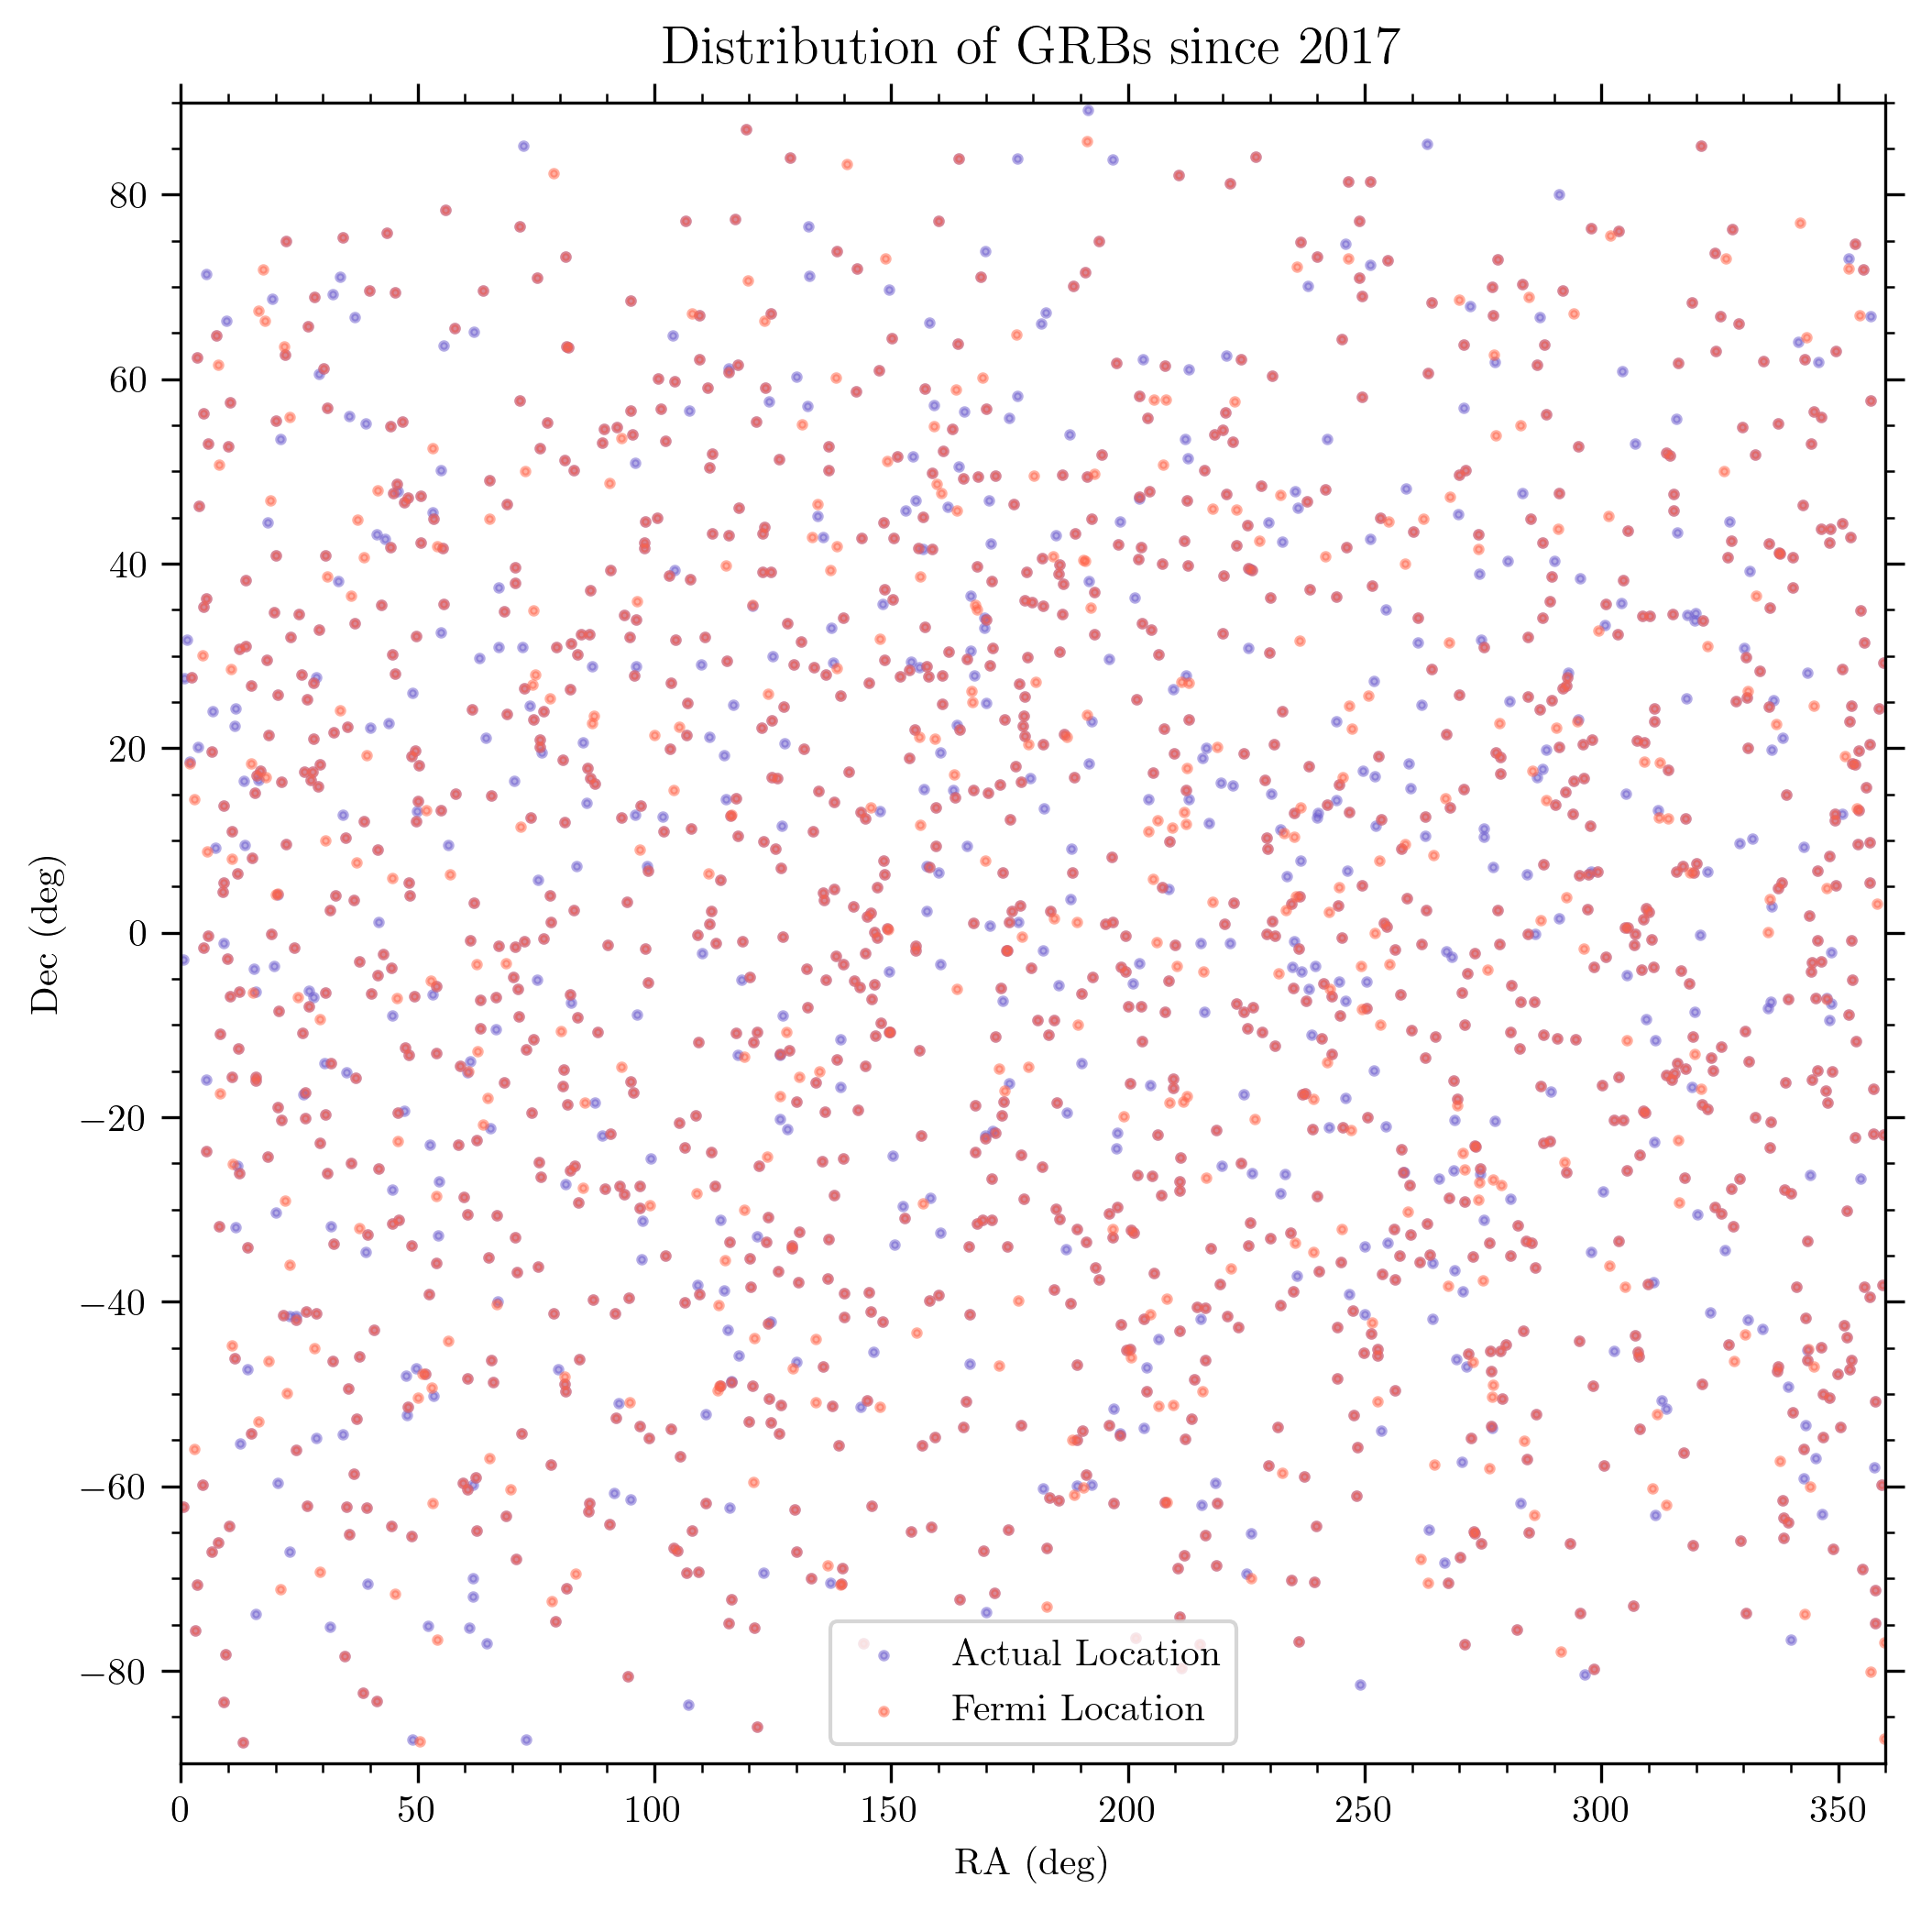

In [40]:
diff = []
ra_fermi, dec_fermi = [], []
for real_name in grb_with_prob:
    ra_real, dec_real = all_grbs[all_grbs['trigger_name']==real_name]['ra'].values[0], all_grbs[all_grbs['trigger_name']==real_name]['dec'].values[0]
    real_trigger = np.unique(u_triggers[u_triggers['url'].str.contains(real_name)]['trigger_no'].values)[0]
    ra, dec = all_triggers[all_triggers['TrigNum']==real_trigger]['RA (J2000) [deg]'].values[0], all_triggers[all_triggers['TrigNum']==real_trigger]['Dec (J2000) [deg]'].values[0]
    c1 = SkyCoord(ra=ra_real*u.degree, dec=dec_real*u.degree, frame='icrs')
    c2 = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    ra_fermi.append(ra)
    dec_fermi.append(dec)
    diff.append(c1.separation(c2).degree)
diff = np.array(diff)
ra_real, dec_real = all_grbs['ra'].values, all_grbs['dec'].values
plt.figure(figsize=(8,8), dpi=300)
plt.scatter(ra_real, dec_real, s=4, color='slateblue', alpha=0.5, label="Actual Location")
plt.scatter(ra_fermi, dec_fermi, s=4, color='tomato', alpha=0.5, label="Fermi Location")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Distribution of GRBs since 2017", fontsize=14, pad=10)
plt.legend()
plt.xlim(0,360)
plt.ylim(-90,90)
plt.show()

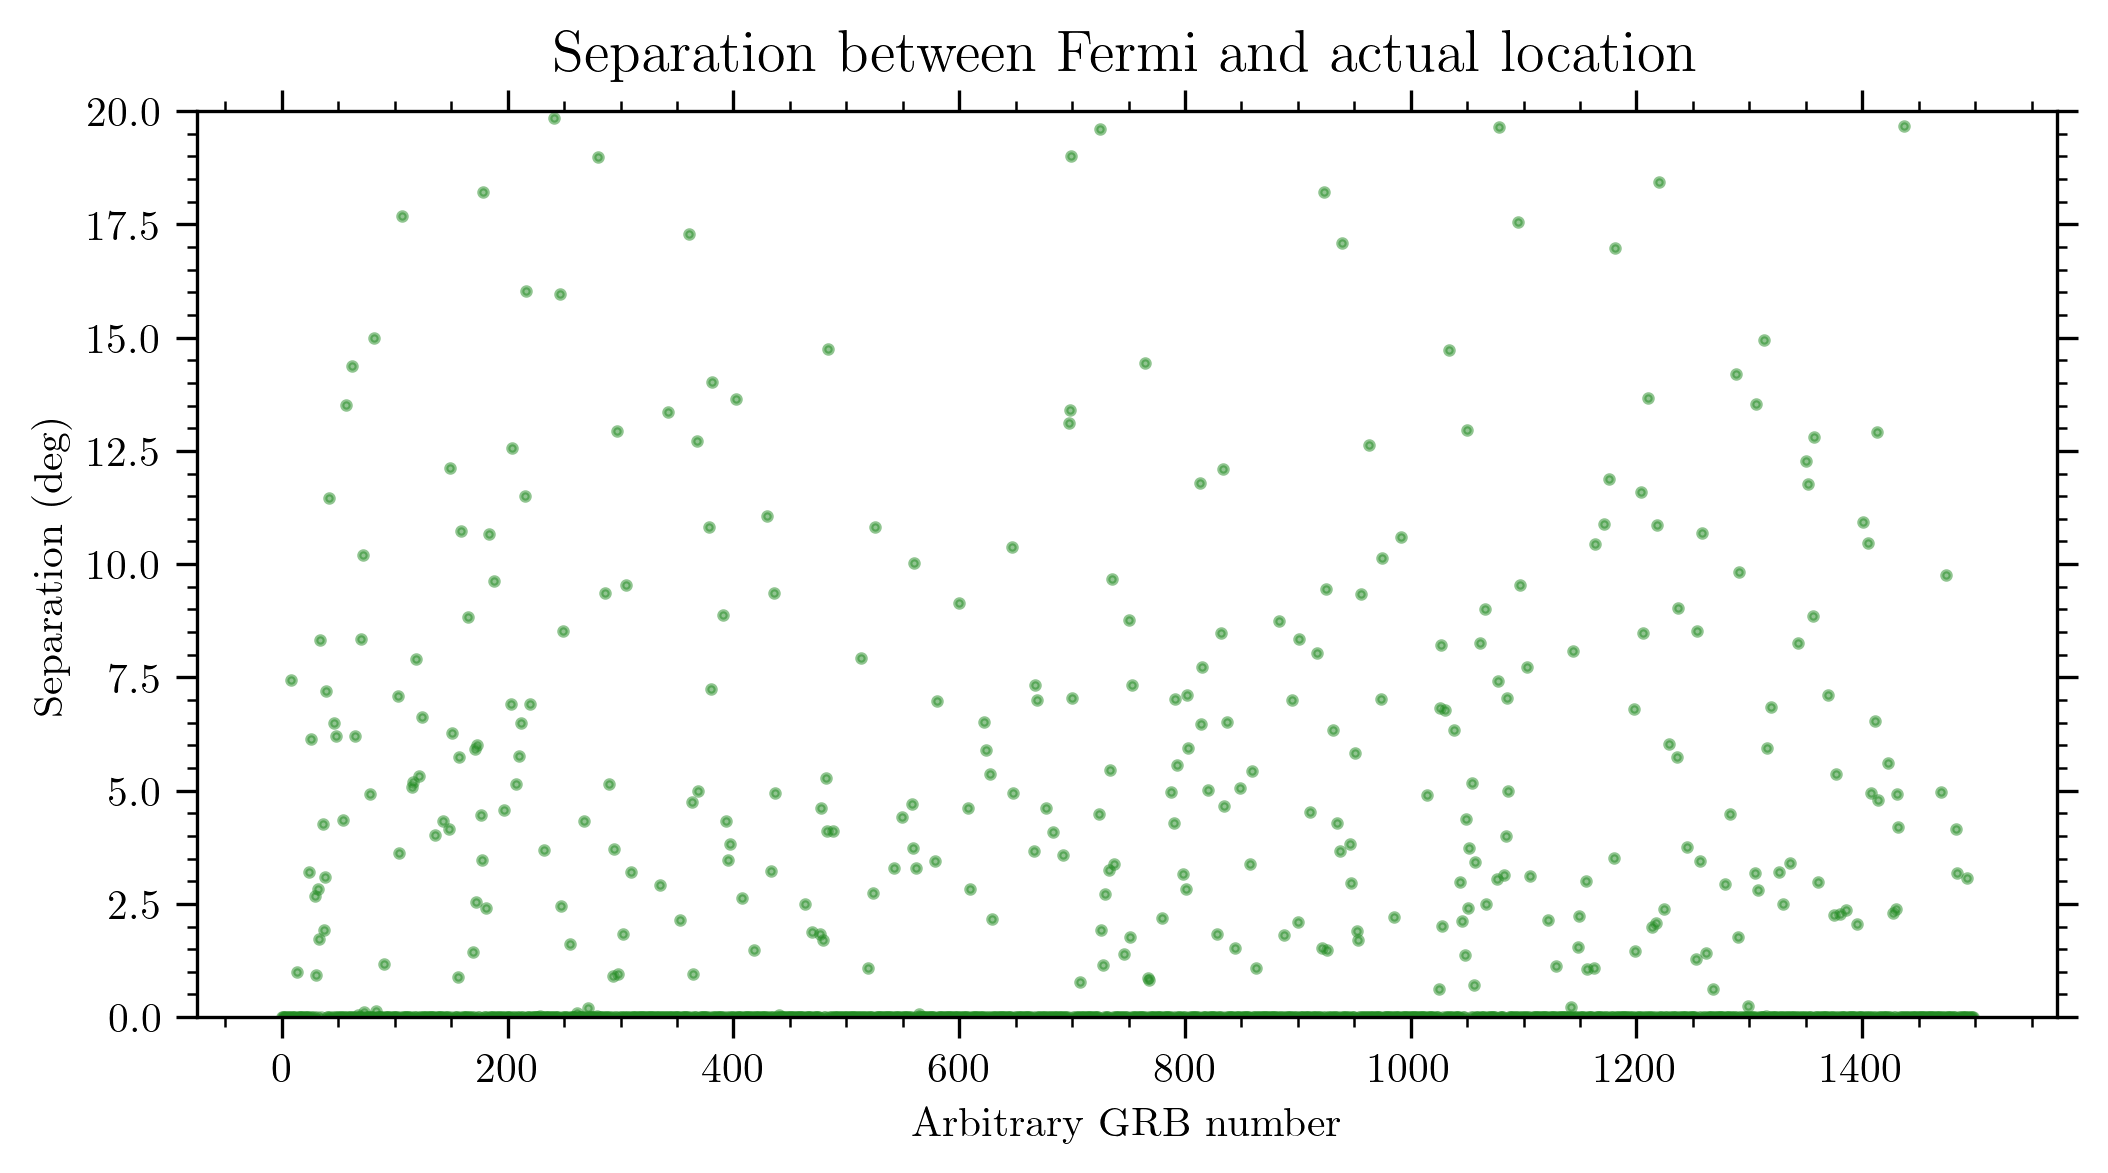

351


In [41]:
plt.figure(figsize=(8,4), dpi=300)
plt.scatter(np.arange(len(diff)),diff, color='forestgreen', alpha=0.5, s=4)
plt.xlabel("Arbitrary GRB number")
plt.ylabel("Separation (deg)")
plt.title("Separation between Fermi and actual location", fontsize=14, pad=10)
plt.ylim(0,20)
plt.show()
print(len(diff[diff>0]))

196608


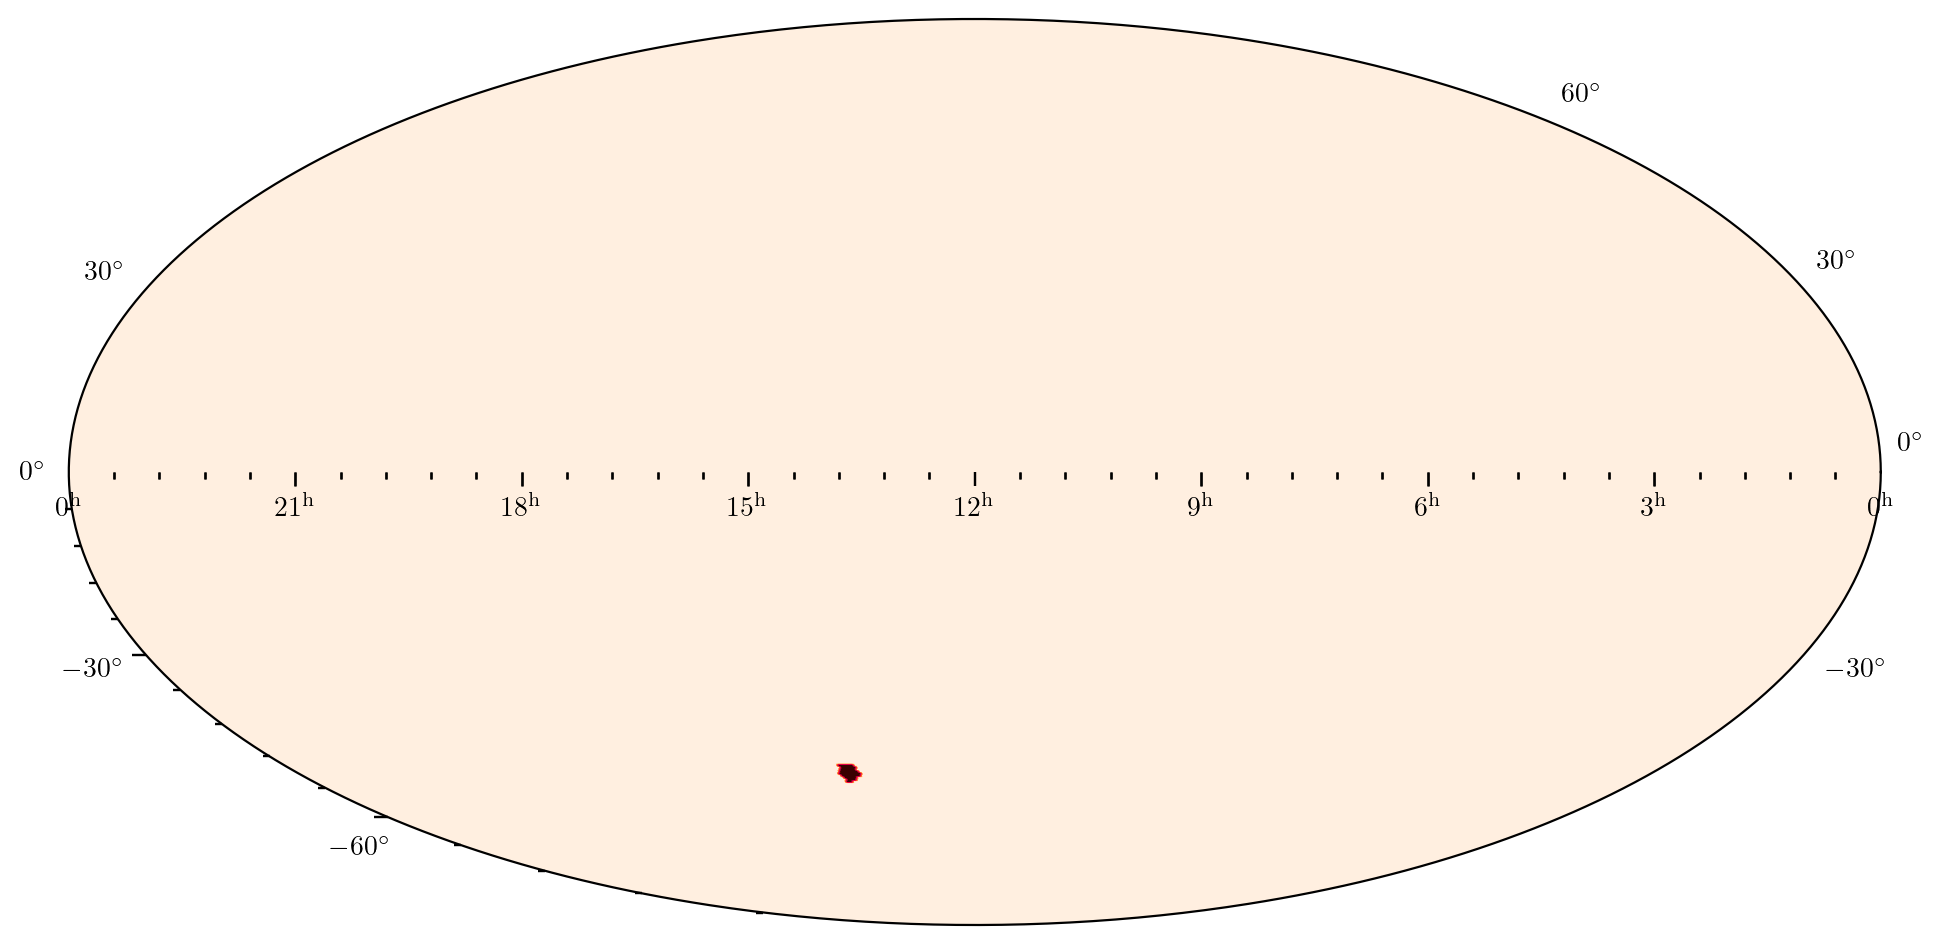

In [42]:
skymap = read_sky_map("/home/ravioli/astro/git/fermi_grbs/data/glg_healpix_all_bn180125891.fit", moc=False)
hpmap = skymap[0]
sortorder = np.argsort(hpmap)[::-1]
hpmap[sortorder[:np.where(np.cumsum(hpmap[sortorder])/np.sum(hpmap)>0.1)[0][0]]] = 1
print(len(hpmap))
fig, axes = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': 'astro hours mollweide'}, dpi=200)
axes.imshow_hpx(hpmap, cmap='cylon')

In [43]:
# def get_obs_times(time, observatory=Observer.at_site("iao"),
#                   exptime=5*u.min, start_time=None, end_time=None):
#     """
#     Make a list of observing times
#     """
#     if start_time is None:
#         if time > observatory.twilight_evening_astronomical(time, 'nearest') and time < observatory.twilight_morning_astronomical(time, 'nearest'):
#             print("Observation will start now")
#             start_time = time
#         else:
#             print("Observation will start at evening twilight")
#             start_time = observatory.twilight_evening_astronomical(time, 'next')
#     if end_time is None:
#         if start_time + 2*u.hour > observatory.twilight_morning_astronomical(start_time, 'next'):
#             print("Observation will end at morning twilight")
#             end_time = observatory.twilight_morning_astronomical(start_time, 'next')
#         else:
#             print("Observation will end 2 hours after start")
#             end_time = start_time + 2*u.hour
#     return np.arange(start_time, end_time, exptime)

In [44]:
# from astroplan import Observer
# from astropy.coordinates import SkyCoord
# sortorder = np.argsort(hpmap)[::-1]
# ra, dec = hp.pix2ang(128,sortorder[:np.where(np.cumsum(hpmap[sortorder])/np.sum(hpmap)>0.9)[0][0]], lonlat=True)
# obs_times = get_obs_times(Time("2021-07-22T00:00:00", format='isot', scale='utc'))
# obs_times = Time(np.array([i.jd for i in obs_times]), format='jd')
# iao = Observer.at_site("iao")
# tile_coords = SkyCoord(ra=ra, dec=dec, unit='deg')
# max_alt = []
# for time in obs_times:
#     aa = iao.altaz(time)
#     target_altaz = tile_coords.transform_to(aa)
#     max_alt.append(np.max(target_altaz.alt.value))
# max_alt = np.array(max_alt)
# obs_times[np.where(max_alt>30)]